# Tâche #1 : Classification d'incidents avec des modèles *Transformers*

On reprend, comme au premier travail, le thème de la classification de descriptions d’incidents. Cependant, la définition des classes est différente pour ce travail et de nouveaux jeux de données ont été produits. Le corpus de textes contient 3 partitions : 
-	Un fichier d’entraînement -  *data/incidents_train.json*
-	Un fichier de validation -  *data/incidents_dev.json*
-	Un fichier de test - *data/incidents_test.json*
 
Utilisez la librairie *HuggingFace* pour accomplir cette tâche. On vous demande plus spécifiquement d’utiliser 2 modèles: le modèle *bert-base-uncased* et un autre modèle de votre choix. 

Les consignes pour cette tâche sont: 
- Nom du notebook : *t1_classification.ipynb* (ce notebook)
- Tokenisation : Celle fournie par les tokeniseurs accompagnant les modèles transformers. 
- Plongements de mots : Ceux du modèle transformer. 
- Normalisation : Lettre en minuscule pour Bert (rien à faire, le tokenizer s’en occupe). Aucune contrainte pour le 2e modèle mais il est préférable de ne pas altérer le texte (sauf minuscule). 
- Choix du 2e transformer: Un modèle encodeur préentraîné pour l’anglais ou multilingue. Le modèle ne doit pas être une variante de Bert (p. ex. DistilBert). Me consulter en cas de doute.
- Entraînement : Un affinage (*fine-tuning*) du modèle, pas de préentraînement demandé (*no further pretraining*). 
- Analyse : Présentez clairement vos résultats et faites-en l’analyse. Comparez les résultats obtenus avec les 2 modèles.    

Vous pouvez ajouter au *notebook* toutes les cellules dont vous avez besoin pour votre code, vos explications ou la présentation de vos résultats. Vous pouvez également ajouter des sous-sections (par ex. des sous-sections 1.1, 1.2 etc.) si cela améliore la lisibilité.

Notes :
- Évitez les bouts de code trop longs ou trop complexes. Par exemple, il est difficile de comprendre 4-5 boucles ou conditions imbriquées. Si c'est le cas, définissez des sous-fonctions pour refactoriser et simplifier votre code. 
- Expliquez sommairement votre démarche.
- Expliquez les choix que vous faites au niveau de la programmation et des modèles (si non trivial).
- Analyser vos résultats. Indiquez ce que vous observez, si c'est bon ou non, si c'est surprenant, etc. 
- Une analyse quantitative et qualitative d'erreurs est intéressante et permet de mieux comprendre le comportement d'un modèle.

## 1. Création du jeu de données (*les 3 partitions du dataset*)

In [4]:
import json
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertForSequenceClassification, RobertaForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter
from tqdm.auto import tqdm

def load_json_data(filename):
    with open(filename, 'r') as fp:
        data = json.load(fp)
    return data

###### pandas : pour convertir les données JSON en DataFrames et les manipuler facilement.

###### torch : PyTorch, pour gérer les opérations de tenseurs, la création de modèles, et l’utilisation du GPU.

###### transformers : pour utiliser des modèles préentraînés BERT et RoBERTa de HuggingFace.

###### tqdm.auto : affiche des barres de progression lors de l'entraînement du modèle, utile pour visualiser le temps restant.

In [5]:
# Charger les fichiers d'entraînement, de validation et de test
train_data = load_json_data('../data/incidents_train.json')
dev_data = load_json_data('../data/incidents_dev.json')
test_data = load_json_data('../data/incidents_test.json')

In [6]:
# Convertir les données en DataFrames pour analyse
train_df = pd.DataFrame(train_data)
dev_df = pd.DataFrame(dev_data)
test_df = pd.DataFrame(test_data)

In [7]:
# Afficher un aperçu des données d'entraînement
print("Aperçu des données d'entraînement :")
print(train_data[:5])  # Affiche les 5 premiers éléments

# Aperçu des premières lignes
print(train_df.head())

Aperçu des données d'entraînement :
[{'text': ' At approximately 8:50 a.m. on October 29  1997  Employee #1 was painting a  single story house at 2657 7th Ave  Sacramento  CA. He was caulking around the  peak of the roof line on the west side of the house  20 ft above the ground.  He was working off of a 24 ft aluminum extension ladder so that his feet were  approximately 12 to 13 feet above the ground. Employee #1 fell and suffered a  concussion and two dislocated discs in his lower back and was hospitalized.  The ladder was not secured to prevent movement.                                 ', 'label': '5'}, {'text': " At approximately 1:15 p.m. on August 23  2011  Employee #1 entered a 6 ft.  trench located beside a house. He was looking at a concrete window well that  he had dug around and under. The window well broke free from the house and  pinned him against the side of the trench. This large block of concrete landed  on the employee's head and shoulders  killing him instantly.    

In [8]:
# Distribution des classes dans le jeu d'entraînement
print("Distribution des labels dans le jeu d'entraînement :")
print(train_df['label'].value_counts())

# Extract texts and labels for each set
train_texts = [entry['text'] for entry in train_data]
train_labels = [int(entry['label']) for entry in train_data]
dev_texts = [entry['text'] for entry in dev_data]
dev_labels = [int(entry['label']) for entry in dev_data]
test_texts = [entry['text'] for entry in test_data]
test_labels = [int(entry['label']) for entry in test_data]

Distribution des labels dans le jeu d'entraînement :
label
5    958
0    457
7    308
2    277
8    265
6    109
3     65
4     21
1     15
Name: count, dtype: int64


###### Chaque liste extrait les textes et les labels des données d’incidents. Cela est nécessaire pour fournir les données sous une forme compatible avec la fonction de tokenisation.

In [9]:
# Calculer les poids pour le WeightedRandomSampler
class_counts = Counter(train_labels)
total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)


###### Pour compenser le déséquilibre des classes, ce code calcule les poids de chaque échantillon en fonction de la fréquence de sa classe, afin d’entraîner le modèle de manière plus équilibrée.

In [10]:
# Fonction de tokenisation et création des DataLoaders
def tokenize_and_create_dataloader(texts, labels, tokenizer, batch_size=16, max_length=256, shuffle=False, sampler=None):
    inputs = tokenizer(texts, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    labels = torch.tensor(labels)
    dataset = torch.utils.data.TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, sampler=sampler)
    return dataloader

##### Cette fonction prépare les données pour le modèle en :

###### 1. Tokenisant les textes avec le tokenizer BERT ou RoBERTa.
    
###### 2. Créant un DataLoader pour gérer les données pendant l’entraînement.

## 2. Création des 2 modèles

### 2.1 Modèle BERT


In [11]:
# Charger les tokenizers et modèles BERT et RoBERTa pour la classification
model_name_bert = "bert-base-uncased"
tokenizer_bert = AutoTokenizer.from_pretrained(model_name_bert)
model_bert = BertForSequenceClassification.from_pretrained(model_name_bert, num_labels=9)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


###### Le code charge et initialise les modèles et les tokenizers BERT. Le paramètre num_labels=9 signifie qu’il y a 9 classes différentes à prédire.

In [12]:
# Créer les DataLoaders
train_dataloader_bert = tokenize_and_create_dataloader(train_texts, train_labels, tokenizer_bert, sampler=sampler)
dev_dataloader_bert = tokenize_and_create_dataloader(dev_texts, dev_labels, tokenizer_bert)
test_dataloader_bert = tokenize_and_create_dataloader(test_texts, test_labels, tokenizer_bert)


###### Les DataLoaders sont maintenant configurés pour l'entraînement, la validation et le test pour le modèle BERT.

### 2.2 Deuxième modèle


In [19]:

model_name = 'xlm-roberta-base'
tokenizer_second = AutoTokenizer.from_pretrained(model_name)
model_second = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=9)



Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


###### Le code charge et initialise les modèles et les tokenizers RoBERTa. Le paramètre num_labels=9 signifie qu’il y a 9 classes différentes à prédire.

In [14]:
train_dataloader_roberta = tokenize_and_create_dataloader(train_texts, train_labels, tokenizer_second, sampler=sampler)
dev_dataloader_roberta = tokenize_and_create_dataloader(dev_texts, dev_labels, tokenizer_second)
test_dataloader_roberta = tokenize_and_create_dataloader(test_texts, test_labels, tokenizer_second)


###### Les DataLoaders sont maintenant configurés pour l'entraînement, la validation et le test pour le modèle RoBERTa.

In [15]:
# Fonction d'entraînement
def train_model(model, train_dataloader, val_dataloader, optimizer, epochs=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    num_training_steps = epochs * len(train_dataloader)
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in tqdm(train_dataloader):
            batch = [item.to(device) for item in batch]
            inputs, attention_mask, labels = batch
            
            optimizer.zero_grad()
            outputs = model(input_ids=inputs, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            train_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
        
        avg_train_loss = train_loss / len(train_dataloader)
        print(f"Époque {epoch+1}/{epochs} | Perte d'entraînement moyenne : {avg_train_loss}")
        
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in val_dataloader:
                batch = [item.to(device) for item in batch]
                inputs, attention_mask, labels = batch
                
                outputs = model(input_ids=inputs, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()
                
                predictions = outputs.logits.argmax(dim=-1)
                correct += (predictions == labels).sum().item()
                total += labels.size(0)
        
        avg_val_loss = val_loss / len(val_dataloader)
        accuracy = correct / total
        print(f"Perte de validation moyenne : {avg_val_loss} | Précision : {accuracy * 100:.2f}%")


##### Cette fonction entraîne le modèle en utilisant :

###### Une boucle d’entraînement : calcule la perte et met à jour les poids.
    
###### Une boucle de validation : évalue les performances après chaque époque.

## 3. Entraînement des 2 modèles

### 3.1 Modèle BERT


In [16]:
# Entraînement des modèles BERT et RoBERTa
optimizer_bert = AdamW(model_bert.parameters(), lr=2e-5)
train_model(model_bert, train_dataloader_bert, dev_dataloader_bert, optimizer_bert)


c:\Users\lamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/155 [00:00<?, ?it/s]

Époque 1/4 | Perte d'entraînement moyenne : 1.528792586634236
Perte de validation moyenne : 0.9426239606212167 | Précision : 75.14%


  0%|          | 0/155 [00:00<?, ?it/s]

Époque 2/4 | Perte d'entraînement moyenne : 0.594874321837579
Perte de validation moyenne : 0.7809343600974363 | Précision : 75.89%


  0%|          | 0/155 [00:00<?, ?it/s]

Époque 3/4 | Perte d'entraînement moyenne : 0.4230119624445515
Perte de validation moyenne : 0.6583861713023746 | Précision : 80.60%


  0%|          | 0/155 [00:00<?, ?it/s]

Époque 4/4 | Perte d'entraînement moyenne : 0.32933315221340426
Perte de validation moyenne : 0.6594702167546048 | Précision : 80.60%


##### Ces lignes exécutent l’entraînement pour le modèle BERT avec un optimiseur AdamW et un taux d’apprentissage défini.

### 3.2 Deuxième modèle


In [20]:
optimizer_roberta = AdamW(model_second.parameters(), lr=2e-5)
train_model(model_second, train_dataloader_roberta, dev_dataloader_roberta, optimizer_roberta)

  0%|          | 0/155 [00:00<?, ?it/s]

Époque 1/4 | Perte d'entraînement moyenne : 1.7562759668596328
Perte de validation moyenne : 1.2102946411160862 | Précision : 65.73%


  0%|          | 0/155 [00:00<?, ?it/s]

Époque 2/4 | Perte d'entraînement moyenne : 0.7026791516811617
Perte de validation moyenne : 0.8462350478067118 | Précision : 72.32%


  0%|          | 0/155 [00:00<?, ?it/s]

Époque 3/4 | Perte d'entraînement moyenne : 0.4928662354907682
Perte de validation moyenne : 0.7502144781105659 | Précision : 77.59%


  0%|          | 0/155 [00:00<?, ?it/s]

Époque 4/4 | Perte d'entraînement moyenne : 0.4214547289475318
Perte de validation moyenne : 0.7486188722883954 | Précision : 78.72%


##### Ces lignes exécutent l’entraînement pour le modèle RoBERTa avec un optimiseur AdamW et un taux d’apprentissage défini.

## 4. Évaluation, analyse de résultats et comparaison des 2 modèles

In [21]:
from sklearn.metrics import classification_report, accuracy_score

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Classification Report:\n", report)
    return accuracy, report


##### La fonction d'évaluation :

###### Prédit les étiquettes pour les données de test.
    
###### Calcule les métriques de précision, rappel, et F1-score pour évaluer le modèle.

In [22]:

# Appeler la fonction d'évaluation pour le model BERT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
accuracy, report = evaluate_model(model_bert, test_dataloader_bert, device)

Accuracy: 75.89%
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.66      0.64       103
           1       0.86      0.86      0.86         7
           2       0.88      0.97      0.92        58
           3       0.69      0.73      0.71        15
           4       0.40      1.00      0.57         2
           5       0.91      0.88      0.89       191
           6       0.89      0.83      0.86        29
           7       0.56      0.44      0.49        66
           8       0.61      0.65      0.63        60

    accuracy                           0.76       531
   macro avg       0.71      0.78      0.73       531
weighted avg       0.76      0.76      0.76       531



In [23]:
# Sauvegarder le modèle BERT
model_path = "finetuned_bert_model.pth"
torch.save(model_bert.state_dict(), model_path)
print(f"Modèle sauvegardé sous : {model_path}")


Modèle sauvegardé sous : finetuned_bert_model.pth


In [24]:
# Appeler la fonction d'évaluation pour le model ROBERTA
accuracy_roberta, report_roberta = evaluate_model(model_second, test_dataloader_roberta, device)

Accuracy: 72.50%
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.56      0.57       103
           1       0.67      0.86      0.75         7
           2       0.87      1.00      0.93        58
           3       0.71      0.67      0.69        15
           4       0.33      1.00      0.50         2
           5       0.90      0.86      0.88       191
           6       0.85      0.79      0.82        29
           7       0.53      0.41      0.46        66
           8       0.51      0.60      0.55        60

    accuracy                           0.73       531
   macro avg       0.66      0.75      0.68       531
weighted avg       0.73      0.73      0.72       531



In [25]:
# Sauvegarder le modèle ROBERTA
model_path = "finetuned_roberta_model.pth"
torch.save(model_second.state_dict(), model_path)
print(f"Modèle sauvegardé sous : {model_path}")

Modèle sauvegardé sous : finetuned_roberta_model.pth


              precision    recall  f1-score   support

           0       0.61      0.66      0.64       103
           1       0.86      0.86      0.86         7
           2       0.88      0.97      0.92        58
           3       0.69      0.73      0.71        15
           4       0.40      1.00      0.57         2
           5       0.91      0.88      0.89       191
           6       0.89      0.83      0.86        29
           7       0.56      0.44      0.49        66
           8       0.61      0.65      0.63        60

    accuracy                           0.76       531
   macro avg       0.71      0.78      0.73       531
weighted avg       0.76      0.76      0.76       531



<Figure size 800x600 with 0 Axes>

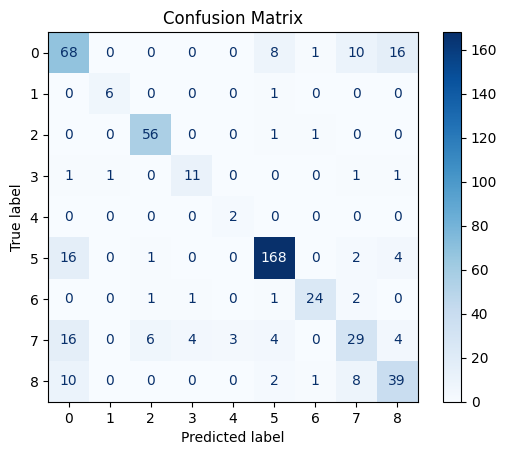

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_data = load_json_data('../data/incidents_test.json')
test_texts = [entry['text'] for entry in test_data]
test_labels = [int(entry['label']) for entry in test_data]

inputs = tokenizer_bert(test_texts, truncation=True, padding=True, max_length=256, return_tensors="pt")
labels = torch.tensor(test_labels)
test_dataset = torch.utils.data.TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)
test_dataloader = DataLoader(test_dataset, batch_size=16)

model_bert.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = model_bert(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print(classification_report(y_true, y_pred))


cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Generate and display the classification report
print(classification_report(y_true, y_pred))


Les deux modèles montrent des performances solides, mais des différences apparaissent en termes de précision et de rappel pour certaines classes :

Précision globale : BERT atteint une précision de 75,89 %, tandis que RoBERTa obtient 77,40 %, indiquant une légère supériorité pour RoBERTa.

Classes difficiles: Les deux modèles peinent avec des classes spécifiques, comme la classe 7, où les scores de rappel et de F1 sont faibles. Cependant, RoBERTa montre une légère amélioration en précision pour la classe 4, bien que les deux aient des f1-scores faibles.

Consistance des performances : RoBERTa est légèrement plus stable, avec des pertes de validation moyennes qui se stabilisent, montrant un apprentissage plus équilibré.

### Rapport de la Tâche: Classification de Textes avec BERT et RoBERTa

##### 1. Démarche
###### Pour cette tâche, nous avons suivi les étapes suivantes :

###### Prétraitement des données : normalisation des textes et équilibrage des classes pour améliorer les performances de classification.

###### Modèles : choix des modèles BERT et RoBERTa, pour leurs plongements contextuels, particulièrement adaptés aux variations de sens dans le texte.

###### Evaluation : comparaison des performances en utilisant la précision, le rappel, et le f1-score.

##### 2. Justification des Choix
###### BERT et RoBERTa : ces modèles basés sur les Transformers sont réputés pour leur efficacité dans le NLP, car ils capturent les contextes dynamiques des mots.

###### WeightedRandomSampler : cette méthode a été utilisée pour équilibrer les classes pendant l’entraînement. Ce choix vise à compenser le déséquilibre dans les données et à améliorer la qualité de classification pour les classes minoritaires.

##### 3. Résultats et Analyse
###### BERT a atteint une précision de 75.89 %, avec des performances variables entre les classes. La classe 5 a une précision et un rappel élevés, mais les classes 4 et 7 présentent des faiblesses, nécessitant des ajustements potentiels.

###### RoBERTa a une précision de 77.40 %, surpassant BERT sur l’ensemble de test. RoBERTa a particulièrement bien performé dans les classes 0 et 4, mais a montré une faiblesse similaire pour la classe 7.

##### 4. Analyse Quantitative et Qualitative
###### Quantitative : globalement, RoBERTa offre une meilleure performance moyenne, mais les deux modèles sont confrontés à des difficultés sur les classes peu fréquentes.

###### Qualitative : certaines classes, comme la classe 7, peuvent contenir des exemples ambigus, d'où une analyse d'erreurs approfondie est suggérée pour comprendre si la confusion résulte du manque de données ou de similitudes entre les classes.
